# Spacial data

In [1]:
# conda install geopandas
# conda install -c conda-forge rtree
# conda install -c conda-forge libspatialindex
# conda install -c conda-forge descartes
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from geopandas.tools import sjoin

%matplotlib inline

sns.set(rc={'figure.figsize':(16, 5)})

## Data

* [Divvy Trip data](https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg) from the City of Chicago (2014 and 2019).

In [2]:
divvy = pd.read_csv('divvy_trips_1419.csv')
print(divvy.shape)
divvy.head()

(6272638, 5)


,TRIP ID,FROM STATION NAME,START TIME,FROM LATITUDE,FROM LONGITUDE
0,1109420,Clark St & Armitage Ave,2014-01-01 00:17:00,41.918306,-87.636282
1,1109421,Damen Ave & Pierce Ave,2014-01-01 00:45:00,41.909396,-87.677692
2,1109427,Sheridan Rd & Irving Park Rd,2014-01-01 01:12:00,41.954245,-87.654406
3,1109431,Bissell St & Armitage Ave,2014-01-01 01:43:00,41.918440,-87.652220
4,1109432,Bissell St & Armitage Ave,2014-01-01 01:43:00,41.918440,-87.652220


In [3]:
### transform cols to datetime
divvy['START TIME'] = pd.to_datetime(divvy['START TIME'], infer_datetime_format=True)
divvy['Year'] = divvy['START TIME'].dt.year


* [Chicago neighborhood boundaries](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9) from the Chicago data portal.

In [4]:
url = 'https://data.cityofchicago.org/resource/y6yq-dbs2.geojson'
neigh = gpd.read_file(url)
print(neigh.shape)
neigh.head()

(98, 5)


,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,48492503.1554,28196.837157,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
1,Printers Row,PRINTERS ROW,2162137.97139,6864.247156,"MULTIPOLYGON (((-87.62761 41.87437, -87.62760 ..."
2,United Center,UNITED CENTER,32520512.7053,23101.363745,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
3,Sheffield & DePaul,SHEFFIELD & DEPAUL,10482592.2987,13227.049745,"MULTIPOLYGON (((-87.65833 41.92166, -87.65835 ..."
4,Humboldt Park,HUMBOLDT PARK,125010425.593,46126.751351,"MULTIPOLYGON (((-87.74060 41.88782, -87.74060 ..."


In [5]:
neigh.dtypes

pri_neigh       object
sec_neigh       object
shape_area      object
shape_len       object
geometry      geometry
dtype: object

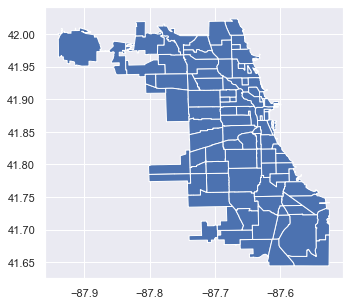

In [6]:
neigh.plot();

## Which neighborhoods have the highest numbers of Divvy trips in 2019?

In [7]:
### number of trips by year and neighborhood

grouped = divvy.groupby(['FROM STATION NAME', 'Year', 
                         'FROM LONGITUDE', 'FROM LATITUDE']).size().to_frame('trips').reset_index()

#grouped.sort_values(by='trips', ascending=False, inplace=True)

print(grouped.shape)
grouped.head(10)

(983, 5)


,FROM STATION NAME,Year,FROM LONGITUDE,FROM LATITUDE,trips
0,2112 W Peterson Ave,2019,-87.683593,41.991178,506
1,63rd St Beach,2019,-87.576120,41.781016,1211
2,900 W Harrison,2014,-87.650019,41.874675,3429
3,900 W Harrison St,2019,-87.649807,41.874754,6643
4,Aberdeen St & Jackson Blvd,2014,-87.654787,41.877726,6939
5,Aberdeen St & Jackson Blvd,2019,-87.654787,41.877726,12140
6,Aberdeen St & Madison St,2014,-87.653929,41.880456,8569
7,Aberdeen St & Monroe St,2019,-87.655519,41.880419,9460
8,Aberdeen St & Randolph St,2019,-87.654264,41.884114,10428
9,Ada St & Washington Blvd,2014,-87.661206,41.882830,5718


In [8]:
#Now let's add a geometry column to the trip data to be able to join it with the neighborhood data
grouped["geom"] = grouped.apply(lambda row: Point(row['FROM LONGITUDE'], row['FROM LATITUDE']) , axis = 1)

print(grouped.shape)
grouped.head()

(983, 6)


,FROM STATION NAME,Year,FROM LONGITUDE,FROM LATITUDE,trips,geom
0,2112 W Peterson Ave,2019,-87.683593,41.991178,506,POINT (-87.683593 41.99117800000001)
1,63rd St Beach,2019,-87.576120,41.781016,1211,POINT (-87.57611976 41.781016372)
2,900 W Harrison,2014,-87.650019,41.874675,3429,POINT (-87.650019 41.874675)
3,900 W Harrison St,2019,-87.649807,41.874754,6643,POINT (-87.649807 41.874754)
4,Aberdeen St & Jackson Blvd,2014,-87.654787,41.877726,6939,POINT (-87.65478743 41.87772613)


In [9]:
# generate dyvvy dataframe with geometry column (using geopandas)
# crs: Coordinate Reference System of the geometry objects. 
gdf = gpd.GeoDataFrame(grouped, geometry='geom', crs=neigh.crs)
gdf = gdf.reset_index()

gdf.head()

,index,FROM STATION NAME,Year,FROM LONGITUDE,FROM LATITUDE,trips,geom
0,0,2112 W Peterson Ave,2019,-87.683593,41.991178,506,POINT (-87.68359 41.99118)
1,1,63rd St Beach,2019,-87.576120,41.781016,1211,POINT (-87.57612 41.78102)
2,2,900 W Harrison,2014,-87.650019,41.874675,3429,POINT (-87.65002 41.87468)
3,3,900 W Harrison St,2019,-87.649807,41.874754,6643,POINT (-87.64981 41.87475)
4,4,Aberdeen St & Jackson Blvd,2014,-87.654787,41.877726,6939,POINT (-87.65479 41.87773)


Now lets join the trip dataset and the neighborhood dataset to be able to tell in which neighborhood did a trip start (this will take some time, be patient)

In [10]:
# spatial join
gdf = gpd.sjoin(neigh, gdf, how='inner')
gdf.sort_values(by='trips', ascending=False, inplace=True)

print(grouped.shape)
gdf.head()

(983, 6)


,pri_neigh,sec_neigh,shape_area,shape_len,geometry,index_right,index,FROM STATION NAME,Year,FROM LONGITUDE,FROM LATITUDE,trips
58,Streeterville,STREETERVILLE,17894338.8151,40084.161471,"MULTIPOLYGON (((-87.61369 41.89313, -87.61369 ...",866,866,Streeter Dr & Grand Ave,2019,-87.612043,41.892278,67983
40,West Loop,WEST LOOP,52945063.8967,43907.671821,"MULTIPOLYGON (((-87.64447 41.85995, -87.64449 ...",127,127,Canal St & Adams St,2019,-87.639904,41.879255,54389
58,Streeterville,STREETERVILLE,17894338.8151,40084.161471,"MULTIPOLYGON (((-87.61369 41.89313, -87.61369 ...",867,867,Streeter Dr & Illinois St,2014,-87.612200,41.891071,54214
40,West Loop,WEST LOOP,52945063.8967,43907.671821,"MULTIPOLYGON (((-87.64447 41.85995, -87.64449 ...",230,230,Clinton St & Madison St,2019,-87.641066,41.882242,49908
26,Loop,LOOP,31485185.0318,52640.907563,"MULTIPOLYGON (((-87.61397 41.88841, -87.61325 ...",507,507,Lake Shore Dr & Monroe St,2019,-87.616743,41.880958,49804


In [11]:
### Divvy trips by neighborhood
gdf = gdf.dissolve(by=['pri_neigh', 'Year'], aggfunc='sum').reset_index()
gdf = gdf.drop(columns=['index_right', 'index', 'FROM LONGITUDE', 'FROM LATITUDE'])
gdf.head()

,pri_neigh,Year,geometry,trips
0,Albany Park,2019,"POLYGON ((-87.70404 41.97355, -87.70403 41.973...",5133
1,Andersonville,2019,"POLYGON ((-87.66114 41.97630, -87.66132 41.976...",6986
2,Armour Square,2019,"POLYGON ((-87.62920 41.84713, -87.62919 41.846...",6107
3,Austin,2019,"POLYGON ((-87.75620 41.91547, -87.75588 41.915...",1810
4,Avalon Park,2019,"POLYGON ((-87.58566 41.75150, -87.58475 41.750...",143


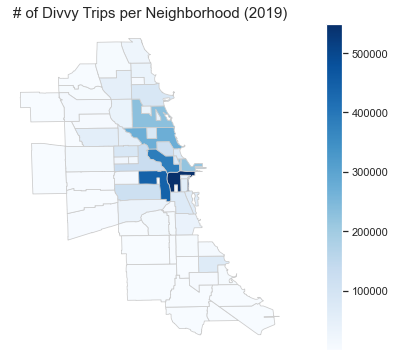

In [12]:
gdf_19 = gdf[gdf.Year == 2019]

# set the range for the choropleth values
vmin, vmax = gdf_19['trips'].min(), gdf_19['trips'].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 6))

# remove the axis
ax.axis('off')

#add a title
ax.set_title('# of Divvy Trips per Neighborhood (2019)', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm)

# create map
gdf_19.plot(column='trips', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8');

## Did trends change over time?

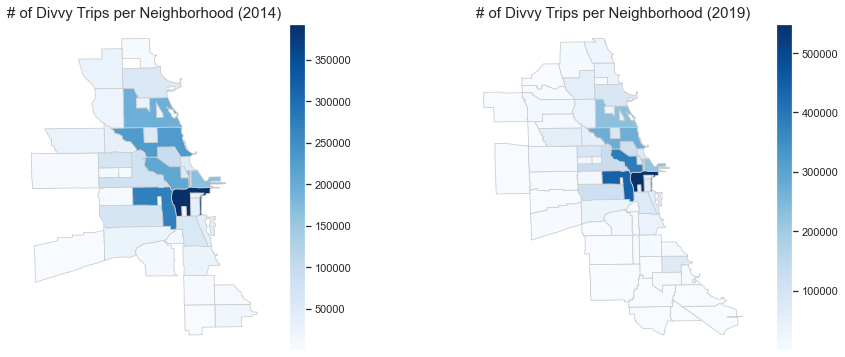

In [13]:
gdf_14 = gdf[gdf.Year == 2014]

# customising the map

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1, ax2 = ax

#year 2014
vmin1, vmax1 = gdf_14['trips'].min(), gdf_14['trips'].max()
ax1.axis('off')
ax1.set_title('# of Divvy Trips per Neighborhood (2014)', fontdict={'fontsize': '15', 'fontweight' : '3'})
sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin1, vmax=vmax1))
sm1._A = []
cbar = fig.colorbar(sm1, ax=ax1)
gdf_14.plot(column='trips', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='0.8');

#year 2018
vmin2, vmax2 = gdf_19['trips'].min(), gdf_19['trips'].max()
ax2.axis('off')
ax2.set_title('# of Divvy Trips per Neighborhood (2019)', fontdict={'fontsize': '15', 'fontweight' : '3'})
sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin2, vmax=vmax2))
sm2._A = []
cbar = fig.colorbar(sm2, ax=ax2)
gdf_19.plot(column='trips', cmap='Blues', linewidth=0.8, ax=ax2, edgecolor='0.8');